In [2]:
%pwd
%matplotlib inline

# Import necessary libraries
# neccasary packages are loaded
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import zipfile
from IPython.display import display, Markdown
from ast import literal_eval
from wordcloud import WordCloud

import random
import os

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

## Introductory words about the dataset

The RecipeNLG dataset (Poznań University of Technology) is an expansion of the Recipe1M+ dataset, offering a significantly larger selection of recipes. Unlike its predecessor, this dataset does not prioritize linking cooking instructions with their corresponding images and instead emphasizes the recipe text, structure, and logic. This updated collection contains over one million newly preprocessed and deduplicated recipes, making it the largest publicly accessible dataset in its field.

The dataset is availabe on Kaggle <https://www.kaggle.com/datasets/saldenisov/recipenlg>.

## Dataset Cleaning & Processing


This cell does not need to be executed because a smaller dataset of ~50000 samples has been generated from the complete 1M+ dataset.

In [15]:
import os
current_path = os.getcwd()
print(current_path)

os.chdir('../dataset/')
path_base_dataset_to_use = os.getcwd()
print(path_base_dataset_to_use)

os.chdir('../dataset_full/')
path_base_dataset_full = os.getcwd()
print(path_base_dataset_full)

os.chdir('../exploratory_data_analysis/')
path_base_notebook = os.getcwd()
print(path_base_notebook)

dataset_full_path = path_base_dataset_full + '/dataset_recipes.csv'
print(dataset_full_path)

df_original = pd.read_csv(dataset_full_path)
df_original.head()


c:\Batool_Data\Durham College - Semester #3\github\Personalized_Recipe_Generator\exploratory_data_analysis
c:\Batool_Data\Durham College - Semester #3\github\Personalized_Recipe_Generator\dataset
c:\Batool_Data\Durham College - Semester #3\github\Personalized_Recipe_Generator\dataset_full
c:\Batool_Data\Durham College - Semester #3\github\Personalized_Recipe_Generator\exploratory_data_analysis
c:\Batool_Data\Durham College - Semester #3\github\Personalized_Recipe_Generator\dataset_full/dataset_recipes.csv


,Unnamed: 0,title,ingredients,directions,link,source,NER
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu..."


In [16]:
df_original_old = df_original[:]

In [72]:
# NUM_DATA_SAMPLES = 50000
# df = df_original.sample(NUM_DATA_SAMPLES, random_state=44)
# df.head()
# path_base = '/teamspace/studios/this_studio/Personalized_Recipe_Recommender/dataset/'
# file_name = 'sampled_dataset_' + str(NUM_DATA_SAMPLES) + '.csv'
# sampled_data_file_path = path_base + file_name
# # df.to_csv('/teamspace/studios/this_studio/Personalized_Recipe_Recommender/dataset/sampled_dataset_10000.csv')
# df.to_csv(sampled_data_file_path)

In [20]:
NUM_DATA_SAMPLES = 50000
for i,part in enumerate(pd.read_csv(dataset_full_path, chunksize=NUM_DATA_SAMPLES)):
    part.to_csv(path_base_dataset_to_use+'/sampled_dataset_part_{}.csv'.format(i), index=False)

### Loading the sampled dataset

In [3]:
import os
current_path = os.getcwd()
print(current_path)

os.chdir('../dataset/')
path_base_dataset = os.getcwd()
print(path_base_dataset)

os.chdir('../exploratory_data_analysis/')
path_base_notebook = os.getcwd()
print(path_base_notebook)

NUM_DATA_SAMPLES = 50000
file_name = '/sampled_dataset_' + str(NUM_DATA_SAMPLES) + '.csv'
sampled_data_file_path = path_base_dataset + file_name

df = pd.read_csv(sampled_data_file_path)
df.head()


c:\Batool_Data\Durham College - Semester #3\github\Personalized_Recipe_Generator\exploratory_data_analysis
c:\Batool_Data\Durham College - Semester #3\github\Personalized_Recipe_Generator\dataset
c:\Batool_Data\Durham College - Semester #3\github\Personalized_Recipe_Generator\exploratory_data_analysis


,Unnamed: 0,ID,name,ingredients,procedure,link,source,NER
0,1254789,1254789,"Bacon, Lettuce, Tomato And Fried Egg Sandwiches","[""4 slices bacon, halved"", ""4 None eggs"", ""4 N...","[""Lightly coat a nonstick frying pan and place...",recipes-plus.com/api/v2.0/recipes/37658,Gathered,"[""bacon"", ""eggs"", ""buns"", ""tomatoes"", ""mayonna..."
1,2162678,2162678,Sauteed Bay Scallops Recipe,"[""2 pound bay scallops"", ""1/4 pound butter, me...","[""Saute/fry onions and parsley in butter."", ""R...",cookeatshare.com/recipes/sauteed-bay-scallops-...,Recipes1M,"[""bay scallops"", ""butter"", ""onions"", ""parsley""..."
2,832049,832049,No Fuss No Mess Chicken And Rice,"[""1 c. uncooked rice"", ""1 chicken, cut up"", ""1...","[""Place rice in oblong pan."", ""Place chicken o...",www.cookbooks.com/Recipe-Details.aspx?id=334186,Gathered,"[""rice"", ""chicken"", ""cream of mushroom soup"", ..."
3,1396186,1396186,Baked Chicken Shawarma,"[""2 teaspoons coriander"", ""1 teaspoon allspice...","[""In a large bowl combine coriander, allspice,...",food52.com/recipes/41562-baked-chicken-shawarma,Gathered,"[""coriander"", ""allspice"", ""cumin"", ""ground gin..."
4,1322877,1322877,Salt-And-Pepper Biscuits,"[""3/4 cup sour cream"", ""4 tablespoons heavy cr...","[""Preheat oven to 425\u00b0F. Whisk sour cream...",www.epicurious.com/recipes/food/views/salt-and...,Gathered,"[""sour cream"", ""heavy cream"", ""baking powder"",..."


### List of Columns

In [9]:
# df = df_original[:]
df.columns

Index(['Unnamed: 0', 'ID', 'name', 'ingredients', 'procedure', 'link',
       'source', 'NER'],
      dtype='object')

The dataset consists of 7 columns:
- id (int): ID.
- title (str): Title of the recipe.
- ingredients (list of str): Ingredients.
- directions (list of str): Instruction steps.
- link (str): URL link.
- source (ClassLabel): Origin of each recipe record, with possible value {"Gathered", "Recipes1M"}:
    1. "Gathered" (0): Additional recipes gathered from multiple cooking web pages using automated scripts in a web scraping process.
    2. "Recipes1M" (1): Recipes from the "Recipe1M+" dataset.

### Column Renaming

In [ ]:
# df.rename(columns={'Unnamed: 0': 'ID','directions': 'procedure', 'title': 'name'},inplace=True, errors='raise')

In [10]:
df.head(10)

,Unnamed: 0,ID,name,ingredients,procedure,link,source,NER
0,1254789,1254789,"Bacon, Lettuce, Tomato And Fried Egg Sandwiches","[""4 slices bacon, halved"", ""4 None eggs"", ""4 N...","[""Lightly coat a nonstick frying pan and place...",recipes-plus.com/api/v2.0/recipes/37658,Gathered,"[""bacon"", ""eggs"", ""buns"", ""tomatoes"", ""mayonna..."
1,2162678,2162678,Sauteed Bay Scallops Recipe,"[""2 pound bay scallops"", ""1/4 pound butter, me...","[""Saute/fry onions and parsley in butter."", ""R...",cookeatshare.com/recipes/sauteed-bay-scallops-...,Recipes1M,"[""bay scallops"", ""butter"", ""onions"", ""parsley""..."
2,832049,832049,No Fuss No Mess Chicken And Rice,"[""1 c. uncooked rice"", ""1 chicken, cut up"", ""1...","[""Place rice in oblong pan."", ""Place chicken o...",www.cookbooks.com/Recipe-Details.aspx?id=334186,Gathered,"[""rice"", ""chicken"", ""cream of mushroom soup"", ..."
3,1396186,1396186,Baked Chicken Shawarma,"[""2 teaspoons coriander"", ""1 teaspoon allspice...","[""In a large bowl combine coriander, allspice,...",food52.com/recipes/41562-baked-chicken-shawarma,Gathered,"[""coriander"", ""allspice"", ""cumin"", ""ground gin..."
4,1322877,1322877,Salt-And-Pepper Biscuits,"[""3/4 cup sour cream"", ""4 tablespoons heavy cr...","[""Preheat oven to 425\u00b0F. Whisk sour cream...",www.epicurious.com/recipes/food/views/salt-and...,Gathered,"[""sour cream"", ""heavy cream"", ""baking powder"",..."
5,413822,413822,Meat Loaf,"[""1 lb. hamburger"", ""1 egg"", ""1 c. bread crumb...","[""Combine all ingredients."", ""Blend well."", ""M...",www.cookbooks.com/Recipe-Details.aspx?id=783405,Gathered,"[""hamburger"", ""egg"", ""bread crumbs"", ""onion"", ..."
6,513148,513148,Beef Quisado,"[""3 c. stew meat (cooked in water until tender...","[""Heat a deep frying pan and add oil."", ""Put i...",www.cookbooks.com/Recipe-Details.aspx?id=23476,Gathered,"[""stew meat"", ""cabbage"", ""onion"", ""green bell ..."
7,2117175,2117175,Omar's Chicken Soup,"[""1 cup chicken broth"", ""4 cups water"", ""3 chi...","[""In a 5 qt pot add vegetable oil and chopped ...",www.food.com/recipe/omars-chicken-soup-325490,Recipes1M,"[""chicken broth"", ""water"", ""chicken"", ""onion"",..."
8,1330196,1330196,Chinese Steamed Black Bean Spareribs,"[""1-1/2 lbs pork sparerib (rib tips)"", ""2 tabl...","[""Cut the spareribs crosswise into 1\"" - 2\"" s...",www.epicurious.com/recipes/member/views/chines...,Gathered,"[""pork sparerib"", ""black bean sauce"", ""Chinese..."
9,1888200,1888200,Seafood Pasta Salad,"[""3 cups uncooked shell pasta"", ""12 cup finely...","[""Cook pasta according to package - drain, rin...",www.food.com/recipe/seafood-pasta-salad-243625,Recipes1M,"[""shell pasta"", ""red pepper"", ""green onion"", ""..."


## Data Preparation

In [11]:
df.head()

,Unnamed: 0,ID,name,ingredients,procedure,link,source,NER
0,1254789,1254789,"Bacon, Lettuce, Tomato And Fried Egg Sandwiches","[""4 slices bacon, halved"", ""4 None eggs"", ""4 N...","[""Lightly coat a nonstick frying pan and place...",recipes-plus.com/api/v2.0/recipes/37658,Gathered,"[""bacon"", ""eggs"", ""buns"", ""tomatoes"", ""mayonna..."
1,2162678,2162678,Sauteed Bay Scallops Recipe,"[""2 pound bay scallops"", ""1/4 pound butter, me...","[""Saute/fry onions and parsley in butter."", ""R...",cookeatshare.com/recipes/sauteed-bay-scallops-...,Recipes1M,"[""bay scallops"", ""butter"", ""onions"", ""parsley""..."
2,832049,832049,No Fuss No Mess Chicken And Rice,"[""1 c. uncooked rice"", ""1 chicken, cut up"", ""1...","[""Place rice in oblong pan."", ""Place chicken o...",www.cookbooks.com/Recipe-Details.aspx?id=334186,Gathered,"[""rice"", ""chicken"", ""cream of mushroom soup"", ..."
3,1396186,1396186,Baked Chicken Shawarma,"[""2 teaspoons coriander"", ""1 teaspoon allspice...","[""In a large bowl combine coriander, allspice,...",food52.com/recipes/41562-baked-chicken-shawarma,Gathered,"[""coriander"", ""allspice"", ""cumin"", ""ground gin..."
4,1322877,1322877,Salt-And-Pepper Biscuits,"[""3/4 cup sour cream"", ""4 tablespoons heavy cr...","[""Preheat oven to 425\u00b0F. Whisk sour cream...",www.epicurious.com/recipes/food/views/salt-and...,Gathered,"[""sour cream"", ""heavy cream"", ""baking powder"",..."


In [17]:
# # Features <link> & <source> do not seem to contribute much valuable info  
# # to the overall dataset. Therefore, removing this data from the dataset
# # df = df.drop(labels='link', axis='columns')
df = df.drop(labels=['Unnamed: 0', 'link', 'source'], axis='columns')
df.head

<bound method NDFrame.head of             ID                                               name  \
0      1254789    Bacon, Lettuce, Tomato And Fried Egg Sandwiches   
1      2162678                        Sauteed Bay Scallops Recipe   
2       832049                   No Fuss No Mess Chicken And Rice   
3      1396186                             Baked Chicken Shawarma   
4      1322877                          Salt-And-Pepper Biscuits    
...        ...                                                ...   
49995   693452                                          The Thing   
49996  2190540     easy to make Chocolate Brownie (tested recipe)   
49997  2129181  Corn, Cheese, and Chili Tamales with Tomatillo...   
49998  1097181                         Four Cheese Spinach Quiche   
49999   515961                             Beef Rolls Cordon Bleu   

                                             ingredients  \
0      ["4 slices bacon, halved", "4 None eggs", "4 N...   
1      ["2 pound bay 

In [77]:
# df.to_csv(sampled_data_file_path)

### Setting the types

In [78]:
# df = df.astype({'ID': int, 
#                 'name': str,
#                 'ingredients': 'object', 
#                 'procedure': 'object', 
#                 'link': str,
#                 'source': 'category', 
#                 'NER': 'object'})

### Adding Extra Columns
The variations in ingredients and their quantities across recipes, as well as the number of steps in each recipe, are of interest.


In [18]:
df['n_NER'] = df['NER'].apply(len)
df['n_procedures'] = df['procedure'].apply(len)

In [19]:
df.head()

,ID,name,ingredients,procedure,NER,n_NER,n_procedures
0,1254789,"Bacon, Lettuce, Tomato And Fried Egg Sandwiches","[""4 slices bacon, halved"", ""4 None eggs"", ""4 N...","[""Lightly coat a nonstick frying pan and place...","[""bacon"", ""eggs"", ""buns"", ""tomatoes"", ""mayonna...",51,335
1,2162678,Sauteed Bay Scallops Recipe,"[""2 pound bay scallops"", ""1/4 pound butter, me...","[""Saute/fry onions and parsley in butter."", ""R...","[""bay scallops"", ""butter"", ""onions"", ""parsley""...",73,380
2,832049,No Fuss No Mess Chicken And Rice,"[""1 c. uncooked rice"", ""1 chicken, cut up"", ""1...","[""Place rice in oblong pan."", ""Place chicken o...","[""rice"", ""chicken"", ""cream of mushroom soup"", ...",93,166
3,1396186,Baked Chicken Shawarma,"[""2 teaspoons coriander"", ""1 teaspoon allspice...","[""In a large bowl combine coriander, allspice,...","[""coriander"", ""allspice"", ""cumin"", ""ground gin...",219,860
4,1322877,Salt-And-Pepper Biscuits,"[""3/4 cup sour cream"", ""4 tablespoons heavy cr...","[""Preheat oven to 425\u00b0F. Whisk sour cream...","[""sour cream"", ""heavy cream"", ""baking powder"",...",130,936


### Cleaning Empty
First lets copy the df

In [25]:
df_old = df[:]

#### Cleaning n_NER column

In [20]:
df = df[df['n_NER'] > 0]

#### Cleaning n_procedures column

In [21]:
df = df[df['n_procedures'] > 0]

In [33]:
# Display the first few rows of the dataset
print("Dataset Head:\n", df.head())

# Display basic information about the dataset
print("\nDataset Info:\n")
df.info()

# Display summary statistics of the dataset
print("\nDataset Description:\n", df.describe())

# Check for missing values
print("\nMissing Values:\n", df.isnull().sum())

# Check for duplicates
print("\nDuplicate Rows:\n", df.duplicated().sum())


Dataset Head:
         ID                                             name  \
0  1254789  Bacon, Lettuce, Tomato And Fried Egg Sandwiches   
1  2162678                      Sauteed Bay Scallops Recipe   
2   832049                 No Fuss No Mess Chicken And Rice   
3  1396186                           Baked Chicken Shawarma   
4  1322877                        Salt-And-Pepper Biscuits    

                                         ingredients  \
0  ["4 slices bacon, halved", "4 None eggs", "4 N...   
1  ["2 pound bay scallops", "1/4 pound butter, me...   
2  ["1 c. uncooked rice", "1 chicken, cut up", "1...   
3  ["2 teaspoons coriander", "1 teaspoon allspice...   
4  ["3/4 cup sour cream", "4 tablespoons heavy cr...   

                                           procedure  \
0  ["Lightly coat a nonstick frying pan and place...   
1  ["Saute/fry onions and parsley in butter.", "R...   
2  ["Place rice in oblong pan.", "Place chicken o...   
3  ["In a large bowl combine coriander, allsp

In [22]:
# Remove duplicate rows
df = df.drop_duplicates()

# Handling missing values
# For simplicity, we will drop rows with missing values. 
# Depending on the data, you may choose to impute missing values.
df = df.dropna()

# Verify that there are no more missing values or duplicates
print("\nMissing Values After Cleaning:\n", df.isnull().sum())
print("\nDuplicate Rows After Cleaning:\n", df.duplicated().sum())



Missing Values After Cleaning:
 ID              0
name            0
ingredients     0
procedure       0
NER             0
n_NER           0
n_procedures    0
dtype: int64

Duplicate Rows After Cleaning:
 0


## Data Analysis

### Unique Values of Recipes

In [26]:
unique_names = len(df['name'].unique())
number_entries = len(df)
number_entries_old = len(df_old)
display(Markdown(f'Number of all entries: {number_entries:.0f} vs Number of all entries before cleaning: {number_entries_old :.0f}'))
display(Markdown(f'Number of unique names: {unique_names :.0f}'))

Number of all entries: 50000 vs Number of all entries before cleaning: 50000

Number of unique names: 41296

## Ingredients

### List of ingredients

In [27]:
NER_exploded = df.explode('NER')
print(f"NER_explode len {len(NER_exploded)}")

ingredients = NER_exploded['NER']
print(ingredients[0:10])

# get the unique values of the exploded column
unique_NER_values = NER_exploded['NER'].unique()
print(len(unique_NER_values))

NER_explode len 50000
0    ["bacon", "eggs", "buns", "tomatoes", "mayonna...
1    ["bay scallops", "butter", "onions", "parsley"...
2    ["rice", "chicken", "cream of mushroom soup", ...
3    ["coriander", "allspice", "cumin", "ground gin...
4    ["sour cream", "heavy cream", "baking powder",...
5    ["hamburger", "egg", "bread crumbs", "onion", ...
6    ["stew meat", "cabbage", "onion", "green bell ...
7    ["chicken broth", "water", "chicken", "onion",...
8    ["pork sparerib", "black bean sauce", "Chinese...
9    ["shell pasta", "red pepper", "green onion", "...
Name: NER, dtype: object
49799


In [28]:
display(Markdown(f'Number of unique ingridients: {len(unique_NER_values) :.0f}'))

Number of unique ingridients: 49799

In [29]:
print(unique_NER_values[:200])

['["bacon", "eggs", "buns", "tomatoes", "mayonnaise"]'
 '["bay scallops", "butter", "onions", "parsley", "lemons", "bread crumbs"]'
 '["rice", "chicken", "cream of mushroom soup", "cream of chicken soup", "onion soup", "water"]'
 '["coriander", "allspice", "cumin", "ground ginger", "turmeric", "cinnamon", "cayenne", "pepper", "salt", "lemon juice", "olive oil", "garlic", "chicken", "pita", "red onion", "parsley", "shredded red cabbage", "tahini"]'
 '["sour cream", "heavy cream", "baking powder", "kosher salt", "sugar", "ground black pepper", "flour", "butter", "salt", "cutter"]'
 '["hamburger", "egg", "bread crumbs", "onion", "milk", "salt", "pepper", "bacon", "catsup"]'
 '["stew meat", "cabbage", "onion", "green bell peppers", "oil", "tomatoes", "garlic", "soy sauce"]'
 '["chicken broth", "water", "chicken", "onion", "vegetables", "garlic", "salt", "fresh cilantro", "potatoes", "vegetable oil"]'
 '["pork sparerib", "black bean sauce", "Chinese rice wine", "cornstarch", "ginger", "garl

There is an issue with the data, as it contains inconsistent naming conventions. For instance, "apples" should be "apple", and different types of cheese should be grouped into a single "cheese" category.



### World Cloud of Ingredients

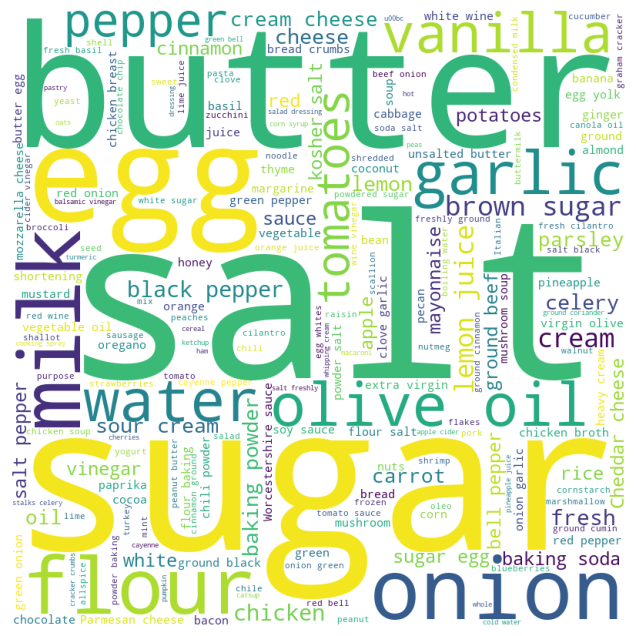

In [31]:
# Generate the word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(' '.join(ingredients[:1000]))

# Display the word cloud using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### World Cloud of Unique Ingredients

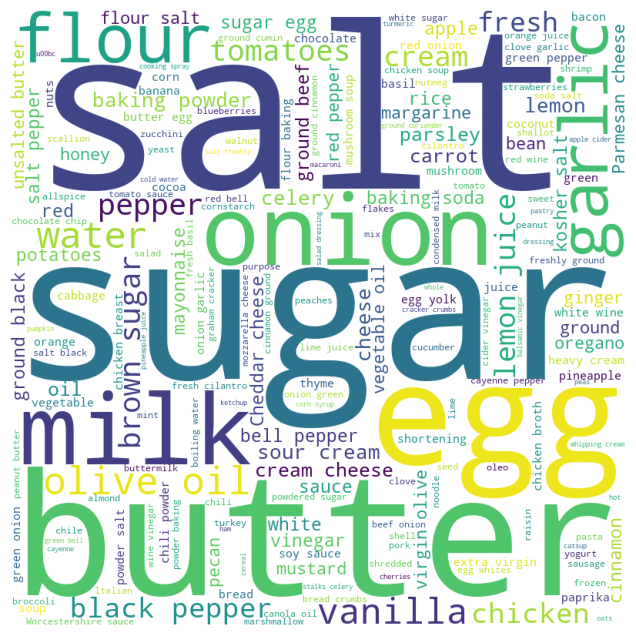

In [32]:
# Generate the word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(' '.join(unique_NER_values[:1000]))

# Display the word cloud using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Tokenize Ingredients and Procedures for NLP Models